## Step1 数据预处理
1. 去除/填补缺失值
2. 换月日处理
3. 因子初筛

In [1]:
from 传统动量指标集 import *
from 传统波动率指标集 import *
from 国泰君安指标计算集 import *
from 世宽指标计算集 import *

import pandas as pd
import 计算函数包 as cf
from tqdm.contrib.concurrent import process_map
from multiprocessing import Pool, cpu_count
from functools import partial
import 回测函数包
import importlib
importlib.reload(回测函数包)
from 回测函数包 import *


In [2]:
# 首先计算因子


if __name__ == "__main__":
    feature_compute_funcs = [
        high_low_5days, high_low_17days,

        volume_std_2days, volume_std_11days, volume_std_21days,

        returns_std_3days, returns_std_27days, returns_last_5days, returns_last_18day, returns_last_2days,

        weighted_avg_return_2, weighted_avg_return_42,

        returns_daliy_max_2days, returns_daliy_max_7days, returns_daliy_max_last_20days,

        sma_weight_con_23_37, sma_weight_con_3_62,

        flipping_weight_29_69, flipping_weight_4_67,

        gj_001, gj_002, gj_003, gj_004, gj_005, gj_006, gj_007, gj_008, gj_009, gj_010,
        gj_011, gj_012, gj_013, gj_014, gj_015, gj_016, gj_017, gj_018, gj_019, gj_020,
        gj_021, gj_022, gj_023, gj_024, gj_025, gj_026, gj_027, gj_028, gj_029, gj_031,
        gj_032, gj_033, gj_034, gj_035, gj_036, gj_037, gj_038, gj_039, gj_040, gj_041,
        gj_042, gj_043, gj_044, gj_045, gj_046, gj_047, gj_048, gj_049, gj_050, gj_051,
        gj_052, gj_053, gj_054, gj_056, gj_057, gj_058, gj_059, gj_060, gj_061, gj_062,
        gj_063, gj_064, gj_065, gj_066,

        wq_001, wq_002, wq_003, wq_004, wq_005, wq_006, wq_007, wq_008, wq_009, wq_010,
        wq_011, wq_012, wq_013, wq_014, wq_015, wq_016, wq_017, wq_018, wq_019, wq_020,
        wq_021, wq_022, wq_023, wq_024, wq_025, wq_026, wq_027, wq_028, wq_029, wq_030,
        wq_031, wq_032, wq_033, wq_034, wq_035, wq_036, wq_037, wq_038, wq_039, wq_040,
        wq_041, wq_042, wq_043, wq_044, wq_045, wq_046, wq_047, wq_049, wq_050, wq_051,
        wq_052, wq_053, wq_054, wq_055, wq_057, wq_065, wq_064, wq_060, wq_061, wq_066,
        wq_068, wq_070, wq_071, wq_072, wq_073, wq_074, wq_075, wq_077, wq_078, wq_081,
        wq_083, wq_085
    ]
    # 读取因子名
    feature_names = [func.__name__ for func in feature_compute_funcs]
    df = pd.read_csv("/Users/wangyanbo/24Spring/intern/MLBasedFuturesStrategy/Dataset/指标已计算/dataset.csv")
    df['date'] = pd.to_datetime(df['date'])
    df = df.loc[df['huanyue'] != 1]
    df = df.loc[df['date'].dt.dayofweek != 4]
    print("已删除所有周五和所有换月日")

    # TODO 修改初筛因子的方法
    ic = cf.information_coefficient(df, feature_list=feature_names)
    features = cf.factor_filter_double(df, ic, number_bar=0.1, top_n=15, ic_bar=0.07125)

    print(features)
    print("指标筛选已完成")


已删除所有周五和所有换月日
{'A': [], 'AG': ['gj_014', 'gj_019', 'returns_last_5days', 'gj_018', 'gj_066', 'gj_065', 'gj_026', 'gj_017', 'gj_046', 'gj_011', 'gj_063', 'gj_003', 'gj_022', 'gj_029', 'gj_047'], 'AL': ['gj_037', 'wq_005', 'wq_070', 'gj_012', 'wq_008'], 'AP': ['wq_025', 'wq_010', 'wq_018', 'wq_033', 'gj_054', 'wq_009', 'flipping_weight_4_67', 'gj_060', 'gj_010', 'flipping_weight_29_69', 'wq_028', 'weighted_avg_return_42', 'wq_035'], 'AU': ['gj_043', 'gj_022', 'returns_last_5days', 'gj_018', 'gj_019', 'gj_014'], 'BC': ['wq_025', 'wq_018', 'wq_010', 'wq_083', 'gj_054', 'wq_017', 'wq_054', 'wq_011', 'wq_009', 'gj_007', 'gj_002', 'wq_028', 'wq_033', 'wq_047', 'wq_066'], 'BU': ['gj_020', 'returns_last_5days', 'gj_018', 'gj_019', 'gj_017', 'gj_011', 'gj_014'], 'C': ['wq_044'], 'CF': ['returns_last_2days', 'returns_daliy_max_2days', 'gj_043', 'weighted_avg_return_2', 'gj_013', 'wq_041'], 'CJ': ['wq_065', 'weighted_avg_return_2', 'gj_046', 'returns_last_2days', 'gj_026', 'gj_027', 'wq_042', 'gj_

## Step2 单一品种的滚动训练
框架保持不变，尝试用lasso或着ridge做滚动训练 + 因子筛选

In [3]:
# 对于给定name的期货进行训练
diction_model = []
# TODO: 如何用上第一步初筛的结果
# selected_features = feature_names

for name in df['id'].unique():
    print(name)
    results = []
    selected_features = feature_names
    columns_to_extract = ['date'] + ['id'] + selected_features + ['returns']
    df_subset = df[df['id'] == name][columns_to_extract]

    # 删除缺失值
    df_subset = df_subset.dropna(thresh=int(len(df_subset)*0.9), axis=1)
    df_subset = df_subset.dropna()
    df_subset.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_subset.fillna(method='ffill', inplace=True)
    df_subset['prediction'] = 0
    df_subset['prediction'] = df_subset['prediction'].astype(float)

    # 将数据前99%取出
    threshold = int(0.99 * len(df_subset))
    if threshold <= 287:
        # 如果某品种过往数据太少，这个品种将不参与运算
        print("当前品种交易数据太少")
        continue
    else:
        df_subset['label'] = np.where(df_subset.index.isin(df_subset.index[:287]), -1, 1)

    # results.append(cf.linear_regression_rolling(df_subset, length=287))
    diction_model.append(df_subset)

sum_length = sum(len(item) for item in diction_model)
print("元素总数是:", sum_length)

A
AG
AL
AP
AU
BC
BU
C
CF
CJ
CS
CU
CY
EB
EG
FG
FU
HC
I
IC
IF
IH
IM
当前品种交易数据太少
J
JD
JM
L
LH
LU
M
MA
NI
NR
OI
P
PB
PF
PG
PK
PP
RB
RM
RU
SA
SC
SF
SI
当前品种交易数据太少
SM
SN
SP
SR
SS
T
TA
TF
UR
V
WR
Y
ZN
元素总数是: 77293


In [4]:


partial_function = partial(cf.linear_regression_rolling, length=287)
# partial_function = partial(cf.rolling_rnn, length = 287)

results = process_map(partial_function, diction_model, max_workers=cpu_count()-1)
prediction = pd.concat(results, ignore_index=True)
print(prediction)
print('滚动训练已结束,即将开始回测')

  0%|          | 0/58 [00:00<?, ?it/s]

            date  id  returns  prediction  label    gj_014    gj_019  \
0     2014-09-02   A -0.00260    0.000000     -1       NaN       NaN   
1     2014-09-03   A -0.00847    0.000000     -1       NaN       NaN   
2     2014-09-04   A  0.00372    0.000000     -1       NaN       NaN   
3     2014-09-09   A  0.00730    0.000000     -1       NaN       NaN   
4     2014-09-10   A -0.00308    0.000000     -1       NaN       NaN   
...          ...  ..      ...         ...    ...       ...       ...   
77288 2023-09-26  ZN -0.01351   -0.000200      1  0.651545  0.520959   
77289 2023-09-27  ZN  0.00232    0.001060      1  0.226245  0.175486   
77290 2023-09-28  ZN  0.01321   -0.000323      1  0.166979  0.125890   
77291 2023-10-09  ZN -0.02529    0.000473      1 -0.007092 -0.019156   
77292 2023-10-10  ZN  0.00306    0.001675      1 -1.035135 -0.868190   

       returns_last_5days    gj_018  gj_066  ...  gj_062  gj_004  wq_021  \
0                     NaN       NaN     NaN  ...     NaN   

In [5]:
print(prediction['prediction'])
print(prediction['prediction'].mean())
print(prediction['prediction'].median())
print(prediction['prediction'].var())
print(sum(prediction['prediction']))
print(sum(abs(prediction['prediction'])))
print(len(prediction['prediction']))
print(sum(abs(prediction['prediction'])) / len(prediction['prediction']))

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
77288   -0.000200
77289    0.001060
77290   -0.000323
77291    0.000473
77292    0.001675
Name: prediction, Length: 77293, dtype: float64
3.684153538123327e-05
0.0
3.02775349018255e-06
2.8475927942216868
63.75705838294741
77293
0.0008248749354139109


In [6]:

data_path = r"/Users/wangyanbo/24Spring/intern/MLBasedFuturesStrategy/Dataset/未连续化/标记了换月日的未连续化的日级数据.csv"
data = pd.read_csv(data_path)
data['date'] = pd.to_datetime(data['date'])
result = data.merge(prediction[['id', 'date', 'label', 'prediction']], on=['id', 'date'], how='left')



      Asset  Open_Time  Open_Price  Direction Close_Time  Close_Price  \
0        AL 2016-08-12     12395.0        1.0 2016-08-12      12350.0   
1        AL 2016-08-16     12335.0        1.0 2016-08-16      12430.0   
2        AL 2016-08-17     12465.0        1.0 2016-08-17      12450.0   
3        AL 2016-08-18     12455.0        1.0 2016-08-18      12780.0   
4        AL 2016-08-23     12380.0        1.0 2016-08-23      12440.0   
...     ...        ...         ...        ...        ...          ...   
20675    UR 2023-09-26      2127.0        1.0 2023-09-26       2142.0   
20676    UR 2023-09-28      2156.0       -1.0 2023-09-28       2158.0   
20677    UR 2023-10-09      2118.0       -1.0 2023-10-09       2162.0   
20678    UR 2023-10-10      2135.0       -1.0 2023-10-10       2042.0   
20679    UR 2023-10-11      2056.0        1.0 2023-10-11       2037.0   

       Predicted_Return  Position  
0              0.001106    6197.5  
1              0.001220    6167.5  
2              

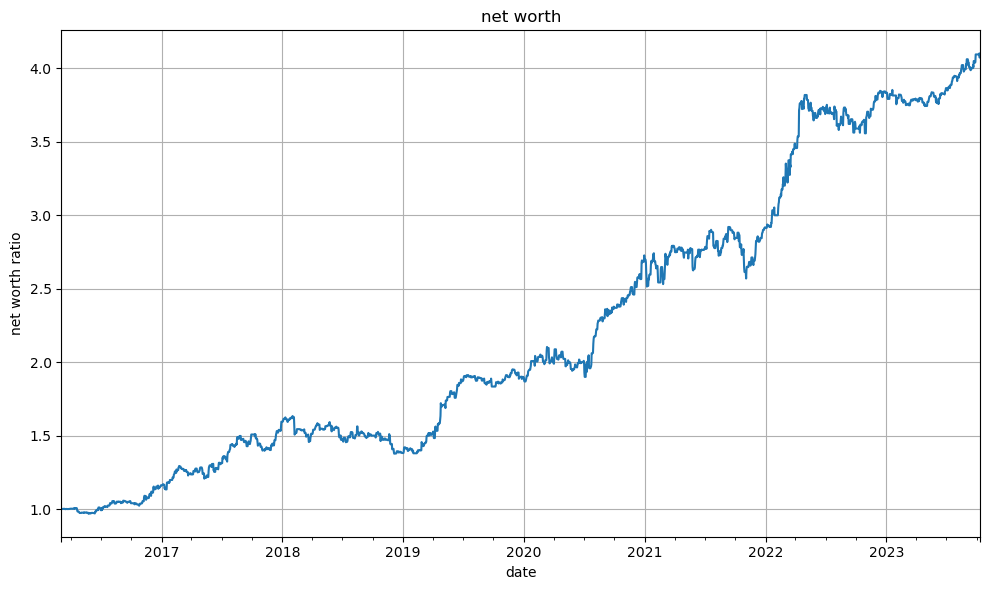

In [7]:
# 使用信号生成函数生成交易记录，此处设置阈值为0.002
bar = 0.001
signals = cf.signals_day(result, bar)
# 使用等市值函数将开仓手数进行等市值处理
# signals = equal_weight_l(signals, 80000, bar)
# 0409 80000, 0.002 800000
signals = equal_weight_l(signals, 80000, bar)
print(signals)
signals['Open_Time'] = pd.to_datetime(signals['Open_Time']).dt.date
daily_transactions = signals.groupby('Open_Time')['Position'].sum()


# 输出回测结果
%matplotlib inline
initial_capital = 800000
record_i_want, df_of_return, daily_return = backtest(initial_capital, signals)


In [8]:
print("Daily Transaction \n", daily_transactions)
print("Max daily Transaction", daily_transactions.max())
print("Max Hands", abs(signals['Direction']).max())
print("Max Position Rate:", daily_transactions.max() / initial_capital)
print("Min daily transaction", daily_transactions.min())

Daily Transaction 
 Open_Time
2016-03-04     17721.6
2016-03-08      9398.4
2016-03-09      9283.2
2016-03-11     18374.4
2016-03-15     18374.4
                ...   
2023-09-27    429370.0
2023-09-28    443861.1
2023-10-09    456829.6
2023-10-10    482464.6
2023-10-11    556444.5
Name: Position, Length: 1479, dtype: float64
Max daily Transaction 763926.55
Max Hands 10.0
Max Position Rate: 0.9549081875000001
Min daily transaction 3535.0000000000005


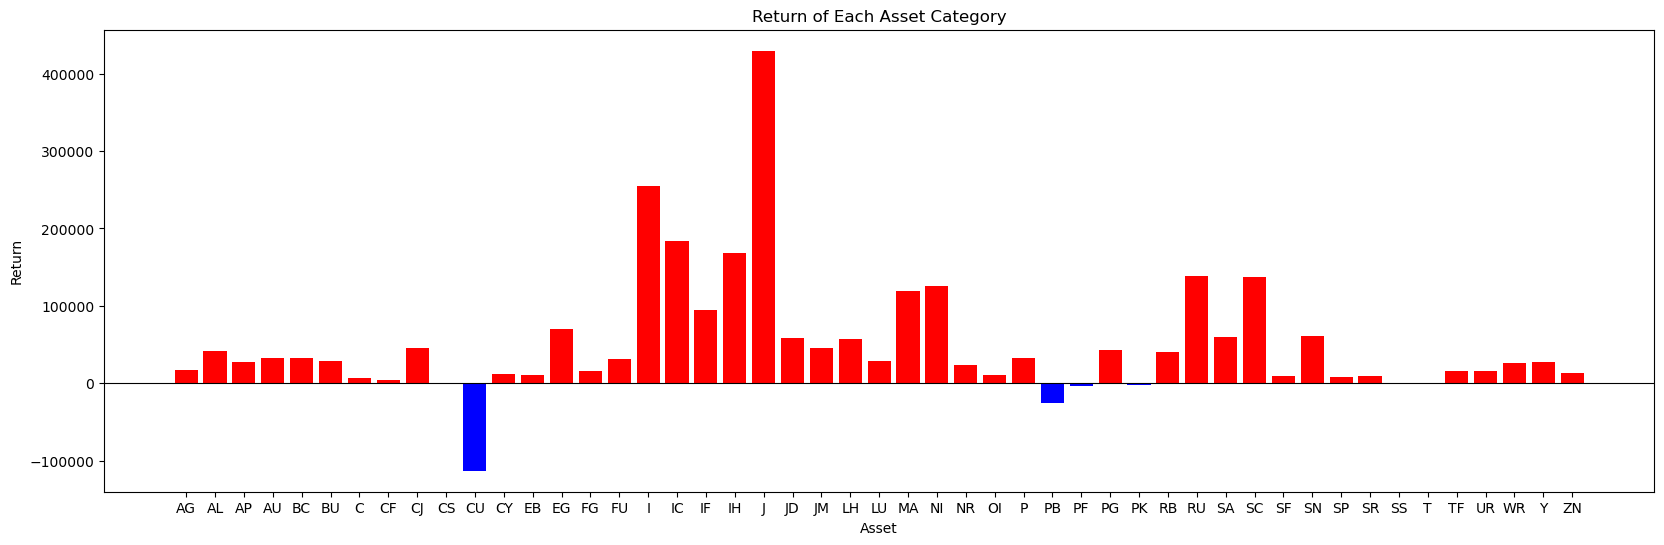

In [9]:
length = len(df_of_return)
# print(length)
# print(len(daily_transactions))
# print(df_of_return)
Categorical_Return = df_of_return.groupby('Asset')['Return'].sum()
# print(Categorical_Return)

plt.figure(figsize=(20, 6))

for asset, return_val in Categorical_Return.items():
    color = 'red' if return_val > 0 else 'blue'
    plt.bar(asset, return_val, color=color)

plt.xlabel('Asset')
plt.ylabel('Return')
plt.title('Return of Each Asset Category')
plt.axhline(0, color='black', linewidth=0.8)  

plt.show()

signals = signals.merge(df_of_return[['Asset', 'Open_Time', 'Return']], on=['Asset', 'Open_Time'], how='left')
signals.to_csv('/Users/wangyanbo/24Spring/intern/日级数据/signals.csv')

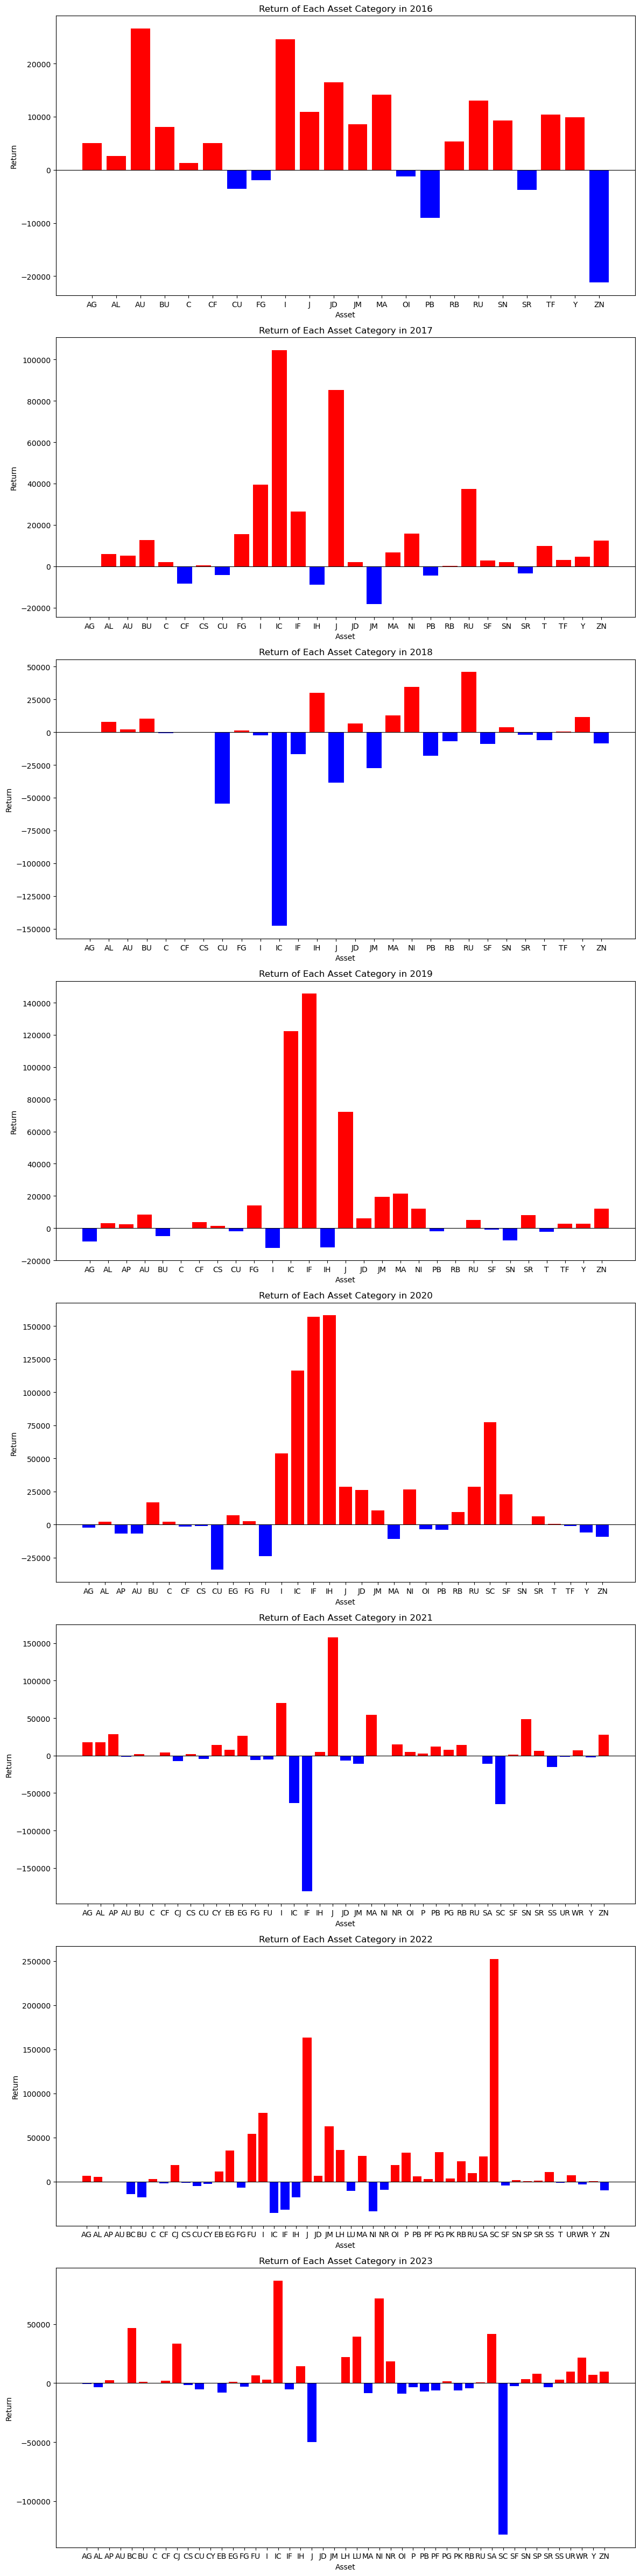

In [10]:
df_of_return['Open_Time'] = pd.to_datetime(df_of_return['Open_Time'])

# Extract year from 'Open_Time'
df_of_return['Year'] = df_of_return['Open_Time'].dt.year

# Group by both 'Asset' and 'Year', then sum the returns
Categorical_Return = df_of_return.groupby(['Asset', 'Year'])['Return'].sum()

# Get unique years
unique_years = df_of_return['Year'].unique()
unique_years.sort()  # Sort years if needed

# Create subplots - one for each year
fig, axs = plt.subplots(len(unique_years), figsize=(12, 6 * len(unique_years)))

# Check if axs is an array (when there's more than one year)
if not isinstance(axs, np.ndarray):
    axs = [axs]

for i, year in enumerate(unique_years):
    # Filter returns for the specific year
    yearly_returns = Categorical_Return.xs(year, level='Year')

    # Plot each asset for the specific year
    for asset, return_val in yearly_returns.items():
        color = 'red' if return_val > 0 else 'blue'
        axs[i].bar(asset, return_val, color=color)

    axs[i].set_title(f'Return of Each Asset Category in {year}')
    axs[i].set_xlabel('Asset')
    axs[i].set_ylabel('Return')
    axs[i].axhline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

Close_Time
2016-03-04      816.0000
2016-03-05        0.0000
2016-03-06        0.0000
2016-03-07        0.0000
2016-03-08      328.0000
                 ...    
2023-10-07        0.0000
2023-10-08        0.0000
2023-10-09     5899.7135
2023-10-10   -22921.5972
2023-10-11     9998.4321
Freq: D, Name: Return, Length: 2778, dtype: float64


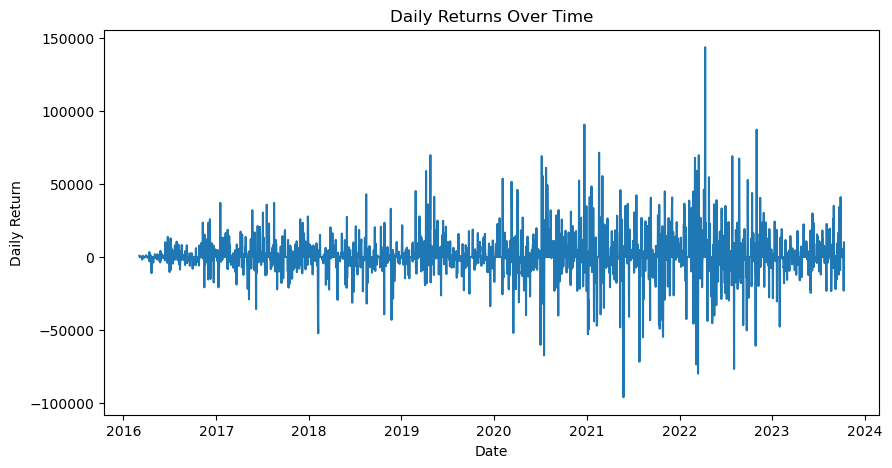

In [11]:
signals['Return'].sum()
print(daily_return)

plt.figure(figsize=(10, 5))
plt.plot(daily_return.index, daily_return)
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()

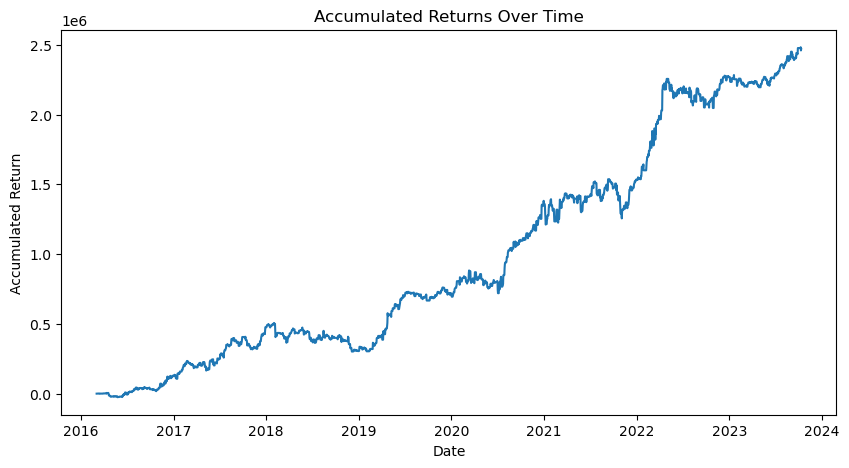

In [12]:
Daily_return = pd.DataFrame(daily_return)
accumulated_return = Daily_return['Return'].cumsum()
plt.figure(figsize=(10, 5))
plt.plot(accumulated_return.index, accumulated_return)
plt.title('Accumulated Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Accumulated Return')
plt.show()

## Step3 策略回测
1. 对于predictions绝对值大于0.5%的日-类别组合，创建交易signal，交易方向由predictions正负决定
2. 用等市值原则平衡交易手数。佣金 = 开盘价格 \* 佣金率，如果佣金小于规定量，就买卖int(规定量/佣金)手数的给定方向、给定日期和类别的期货. 修改佣金的计算方法

# Step4 部分品种的滚动训练和回测
和Step 2, 3相似，在训练中考虑更多的交易种类

# Step5 全品种的滚动训练和回测
和step 4相似，考虑所有的交易种类